# Introduction

This notebook assumes you have activated credentials with the CAVE client. CAVE (Connectome Annotation Versioning Engine) is built and supported by a collaboration between the Seung lab at Princeton and the Allen Institute for Brain Science. It allows for programmatic access to the tables associated with Minnie and other datasets. [Github](https://github.com/seung-lab/CAVEclient) 

CAVE setup instructions are [here](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/CAVEsetup.ipynb).

CAVE tutorial for querying the data is [here](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/SynapseAndAnnotationQuery.ipynb).

## Using CAVEclient to query data

In [1]:
from caveclient import CAVEclient

Load the public client for accessing the datastack in CAVE. If you have not acquired an authentication token, run the code below to get a new token. You will need to link your Google account.

In [2]:
# this is the datastack name of the public release
# passing it will auto-configure many of the services
client = CAVEclient('minnie65_public_v117')

### View available annotation tables

In [3]:
client.materialize.get_tables()

['nucleus_detection_v0',
 'synapses_pni_2',
 'nucleus_neuron_svm',
 'proofreading_status_public_release',
 'func_unit_em_match_release',
 'allen_soma_ei_class_model_v1',
 'allen_visp_column_soma_coarse_types_v1']

### Query functionally matched EM neurons

In [4]:
import pandas as pd

In [5]:
matched_df = client.materialize.query_table('func_unit_em_match_release')
matched_df

,id,valid,pt_supervoxel_id,pt_root_id,session,scan_idx,unit_id,pt_position
0,1,t,111892900580825107,864691135771728459,9,4,5443,"[342768, 110096, 16982]"
1,2,t,113374561219162796,864691136056503512,5,6,4163,"[353824, 139168, 17340]"
2,3,t,114151228744823805,864691135759645885,6,6,6173,"[359104, 158528, 16988]"
3,4,t,113591508741325495,864691136023817529,7,4,12641,"[355312, 182976, 18283]"
4,5,t,113101126421131388,864691135847929438,5,6,8571,"[351568, 199024, 17264]"
...,...,...,...,...,...,...,...,...
195,196,t,84028802904693239,864691135341053381,9,4,8277,"[140208, 124336, 24049]"
196,197,t,87199863091540257,864691136922717668,9,3,2477,"[162976, 157856, 23478]"
197,198,t,87272705870770932,864691135272254225,6,7,6978,"[163824, 176048, 24252]"
198,199,t,86994941611767343,864691135490575335,8,5,10211,"[161344, 203952, 23381]"


### Column descriptions:

<b>id:</b> a unique identifier for this row

<b>valid:</b> internal check, uniformly ‘t’

<b>pt_position_{x,y,z}:</b> the location in 4,4,40 nm voxels at a cell body for the cell

<b>pt_supervoxel_id:</b> the ID of the supervoxel from the watershed segmentation that is under the pt_position

<b>pt_root_id:</b> the ID of the segment/root_id under the pt_position from the Proofread Segmentation (v117).

<b>session:</b> the ID indicating the imaging period for the mouse

<b>scan_idx:</b> the index of the scan within the imaging session

<b>unit_id:</b> the ID of the functional ROI (unique per scan)

### Select a random entry

In [6]:
entry = matched_df.sample(1)
entry

,id,valid,pt_supervoxel_id,pt_root_id,session,scan_idx,unit_id,pt_position
134,135,t,93892727741456662,864691135155750244,6,2,8578,"[211552, 215808, 22808]"


In [7]:
segment = entry.pt_root_id.values[0] # get ID of segment to visualize
centroid = entry.pt_position.values[0] # get centroid of segment

## View entry in Neuroglancer

### Flat segmentation

The flat segmentation is a complete segmentation of the entire Minnie volume. It is fast-loading, with multi-scale 3D meshes. It is currently on v117 public.

Programmatic editing of Neuroglancer links can be accomplished using the Seung lab/ AIBS package [nglui](https://github.com/seung-lab/NeuroglancerAnnotationUI).

```python
pip install nglui
```

[Example notebook](https://github.com/seung-lab/NeuroglancerAnnotationUI/blob/master/examples/statebuilder_examples.ipynb)

In [8]:
from nglui import statebuilder # generate links in Seung lab a custom Neuroglancer deployment called Neuromancer

In [9]:
em_layer = statebuilder.ImageLayerConfig("precomputed://https://bossdb-open-data.s3.amazonaws.com/microns/minnie/minnie65-phase3-em/aligned/v1") # public em source
seg_layer = statebuilder.SegmentationLayerConfig("precomputed://gs://iarpa_microns/minnie/minnie65/seg", name='seg', fixed_ids=[segment]) # public segmentation source

view_options = {'layout': '3d',
                'zoom_3d': 3000,
                'position': centroid} # set zoom options and center on segment

sb = statebuilder.StateBuilder([em_layer, seg_layer], view_kws=view_options)

sb.render_state(url_prefix='https://ngl.microns-explorer.org/', return_as='html')

### Dynamic segmentation

The dynamic segmentation is a live-view of the current segmentation and mesh state that is altered by proofreading. **(It may take awhile to load)**

It is viewable in a modified version of Neuroglancer and accessible with [nglui](https://github.com/seung-lab/NeuroglancerAnnotationUI).

In [10]:
em_layer = statebuilder.ImageLayerConfig(client.info.image_source(), contrast_controls=True, black=0.35, white=0.7) # set EM layer 
seg_layer =  statebuilder.SegmentationLayerConfig(client.info.segmentation_source(),  name='seg', fixed_ids=[segment]) # set dynamic segmentation layer
view_options = {'layout': '3d',
                'zoom_3d': 3000,
                'position': centroid}  # set zoom options and center on segment

sb = statebuilder.StateBuilder([em_layer, seg_layer], view_kws=view_options) # generate statebuilder
sb.render_state(return_as='html') # render state as html link

# Access Functional data

This notebook assumes you have access to a copy of the SQL database that houses the functional data and the functional data schema repository. Instructions to download are [here](https://www.microns-explorer.org/cortical-mm3#f-data).

The contents of the SQL schema are accessed programmatically using [DataJoint](https://datajoint.io/). Find an example notebook for using DataJoint to access the functional data [here].

In [11]:
import datajoint as dj

dj.config['database.host'] = 'functional-em.crjvviai1xxh.us-west-2.rds.amazonaws.com'
dj.config['database.user'] = 'read_only'
dj.config['database.password'] = 'secret'
dj.config['database.database']='test_user_db'

In [12]:
%%capture
import datajoint as dj
from phase3 import nda, func, utils

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Convert entry to DataJoint compatible key

DataJoint tables can be restricted with dictionaries. Here we generate a dictionary of attributes that specify the unique functional ROI in the DataJoint schema. 

In [13]:
unit_key = entry[['session', 'scan_idx', 'unit_id']].to_dict(orient='records')[0]
unit_key

{'session': 6, 'scan_idx': 2, 'unit_id': 8578}

### Fetch & plot activity trace, calcium trace, pupil radius, and treadmill

Here we use the key to fetch and plot a variety of data from the schema, including the unit's calcium & spike traces, and the scan's pupil trace and treadmill speed. 

Note: The `nda.ManualPupil` and `nda.Treadmill` tables only contain the `session` and `scan_idx` attributes, but can still be retrieved with the `unit_key`. The `unit_id` attribute is ignored when restricting against these tables.

In [14]:
nframes, fps = (nda.Scan & unit_key).fetch1('nframes', 'fps')  # fetch # frames and fps
time_axis = np.arange(nframes)/ fps # create time axis (seconds)
spike_trace = (nda.Activity & unit_key).fetch1('trace') # fetch spike trace
calcium_trace = (nda.ScanUnit * nda.Fluorescence & unit_key).fetch1('trace') # fetch calcium fluorescence trace
pupil_radius = (nda.ManualPupil & unit_key).fetch1('pupil_maj_r') # fetch manually segmented pupil trace 
treadmill = (nda.Treadmill & unit_key).fetch1('treadmill_velocity') # fetch treadmill speed

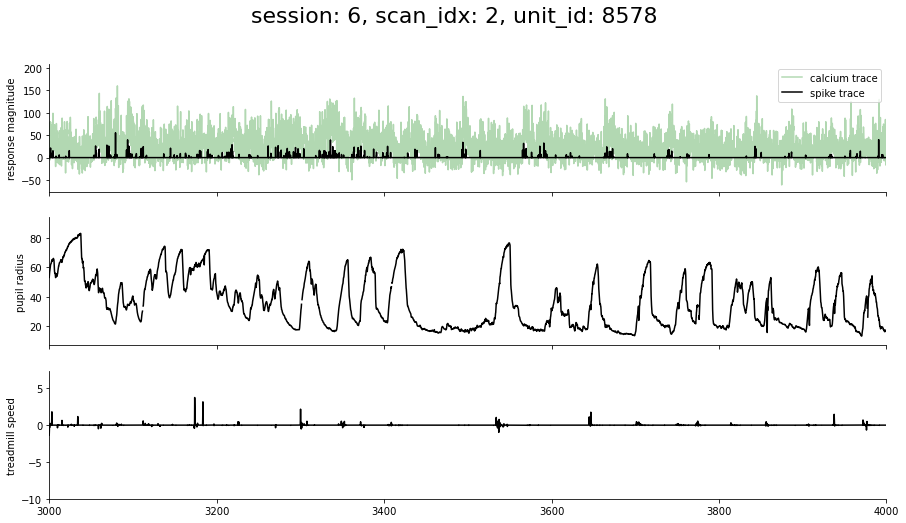

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
ax1.plot(time_axis, calcium_trace, color='g', alpha=0.3, label='calcium trace')
ax1.plot(time_axis, spike_trace, color='k', label='spike trace')
ax2.plot(time_axis, pupil_radius, color='k')
ax3.plot(time_axis, treadmill, color='k')
ax3.set_xlim(3000, 4000) 
ax1.set_ylabel('response magnitude')
ax1.legend()
ax2.set_ylabel('pupil radius')
ax3.set_ylabel('treadmill speed')
fig.suptitle(f'session: {unit_key["session"]}, scan_idx: {unit_key["scan_idx"]}, unit_id: {unit_key["unit_id"]}', fontsize=22);
[ax.spines['right'].set_visible(False) for ax in [ax1, ax2, ax3]];
[ax.spines['top'].set_visible(False) for ax in [ax1, ax2, ax3]];

### Plot oracle raster

Here we use a function provided in the `func` module to retrieve the responses for the functional unit for the repeated stimulus trials (oracle trials). For a further description of the oracle see the technical documentation.

In [16]:
oracle_rel = (dj.U('condition_hash').aggr(nda.Trial & unit_key,n='count(*)',m='min(trial_idx)') & 'n=10')

In [17]:
oracle_rel

condition_hash 120-bit hash (The first 20 chars of MD5 in base64),n calculated attribute,m calculated attribute
5zQTb77qI+ig8rigx1XU,10,36
7UETOWO5Z8aWuHDBJ2GG,10,39
ecUQJtcERZJGdqza1k7h,10,35
GjCMo2GkJp6y5vricadg,10,34
KXdTNAGMo1gCWz2Ge8zr,10,38
Oup5uAZxF2G7zEJkT+ui,10,37


In [18]:
type(oracle_rel)

datajoint.expression.Aggregation

In [19]:
oracle_hashes, m = oracle_rel.fetch('condition_hash','m',order_by='m ASC')

In [20]:
oracle_traces, score = func.fetch_oracle_raster(unit_key)

Text(0.5, 1.2, 'session: 6, scan_idx: 2, unit_id: 8578')

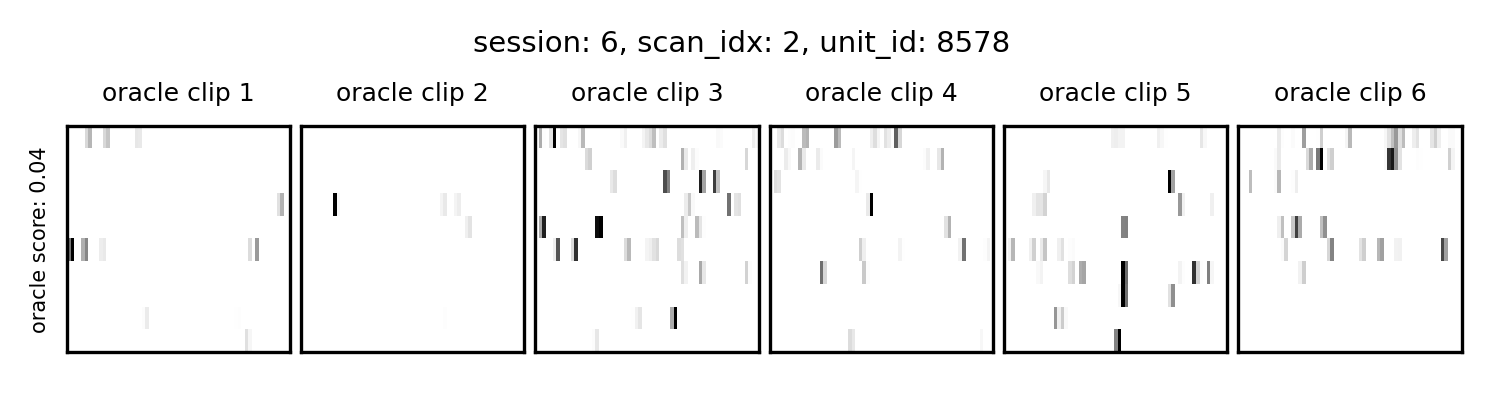

In [21]:
fig,axes = plt.subplots(1,6, figsize=(6,1),dpi=300)
for col,clip_trace in zip(axes,np.moveaxis(oracle_traces,1,0)):
    col.imshow(clip_trace,cmap='binary', interpolation='nearest')
    col.set_aspect('auto')
    col.set_xticks([])
    col.set_yticks([])
axes[0].set_ylabel(f'oracle score: {score:.2f}', fontsize=5)
fig.subplots_adjust(wspace=.05)
[ax.set_title(f'oracle clip {i+1}', fontsize=6) for i, ax in enumerate(axes)];
fig.suptitle(f'session: {unit_key["session"]}, scan_idx: {unit_key["scan_idx"]}, unit_id: {unit_key["unit_id"]}', fontsize=7, y=1.2)